<a href="https://colab.research.google.com/github/Amana28/Deep-Learning/blob/master/Amana_11_Huggingface_Text_Classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment: Classifying authors with DistilBERT
Please use the HuggingFace Transformer library for author classification:
* use the DistilBERT architecture this time,
* collect data from 4 authors,
* create, train and evaluate a classifier with DistilBERT and 4 authors.



In [1]:
%%capture
!pip install tensorflow transformers
!python -m spacy download en

In [2]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import spacy
from urllib.request import urlretrieve
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## 1. Exercise: Dataset acquisition

In [3]:
nlp = spacy.load("en_core_web_sm")

def sentencesSplit(raw_text):
  doc = nlp(raw_text)
  sentences = [sent.text for sent in doc.sents]
  return sentences


In [4]:
book1="http://www.gutenberg.org/files/2151/2151-0.txt" # Edgar Allan Poe
book2="https://www.gutenberg.org/cache/epub/70589/pg70589.txt" # Edgar Rice Burroughs
book3="https://www.gutenberg.org/files/59824/59824-0.txt" # Robert Frost
book4="https://www.gutenberg.org/cache/epub/12242/pg12242.txt" # Emily Dickinson
urlretrieve(book1, 'book1.txt') 
urlretrieve(book2, 'book2.txt')
urlretrieve(book3, 'book3.txt')
urlretrieve(book4, 'book4.txt')
book1_text = open("book1.txt", encoding='utf-8').read().lower()
book2_text = open("book2.txt", encoding='utf-8').read().lower()
book3_text = open("book3.txt", encoding='utf-8').read().lower()
book4_text = open("book4.txt", encoding='utf-8').read().lower()

In [5]:
book1_sents = sentencesSplit(book1_text)
book2_sents = sentencesSplit(book2_text)
book3_sents = sentencesSplit(book3_text)
book4_sents = sentencesSplit(book4_text)

In [6]:
TRAIN_SIZE = 0.8
t_split_1  = int(TRAIN_SIZE*len(book1_sents))
t_split_2  = int(TRAIN_SIZE*len(book2_sents))
t_split_3  = int(TRAIN_SIZE*len(book3_sents))
t_split_4  = int(TRAIN_SIZE*len(book4_sents))

In [7]:
X_train = book1_sents[:t_split_1] + book2_sents[:t_split_2] + book3_sents[:t_split_3] + book4_sents[:t_split_4]
Y_train = np.concatenate((np.zeros(t_split_1), np.ones(t_split_2), np.full(t_split_3, 2), np.full(t_split_4, 3)))

X_test  = book1_sents[t_split_1:] + book2_sents[t_split_2:] + book3_sents[t_split_3:] + book4_sents[t_split_4:] 
Y_test  = np.concatenate((np.zeros((len(book1_sents)-t_split_1)), np.ones((len(book2_sents)-t_split_2)), np.full((len(book3_sents)-t_split_3), 2), np.full((len(book4_sents)-t_split_4), 3)))

# 2. Exercise: Data preparation

We are using [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, in which we have to convert each sentence into a tuple containing the text's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and the corresponding [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask). In order to do so, the corresponding tokizer can be used: [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)

We trim or pad the processed sentences to MAX_LEN (due to `truncation=True` and `padding=True` parameters) - this is an easy solution to handle inputs with different lengths.

In [34]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 128

sample = X_train[100]

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
inputs = tokenizer.encode_plus(
    sample,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f'sentence: \'{sample}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

sentence: 'there are, nevertheless, three or
      four female heads, of an ethereal beauty-portraits in the manner of sully.
      '
input ids: tensor([[  101,  2045,  2024,  1010,  6600,  1010,  2093,  2030,  2176,  2931,
          4641,  1010,  1997,  2019, 28855, 15879,  5053,  1011,  9668,  1999,
          1996,  5450,  1997, 21396,  2135,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0, 

This transformation must be applied to each sentence in the corpus. Here's how we do it: `construct_encodings` maps the tokenizer to each `sentence` and aggregates them:

In [9]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings_train = construct_encodings(X_train, tokenizer, max_len=MAX_LEN)
encodings_test  = construct_encodings(X_test, tokenizer, max_len=MAX_LEN)

Now we have to convert the `encodings` and `y` (which holds the classes of the authors) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):



In [10]:
def construct_tfdataset(encodings, y=None):
    if y is not None:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset_train = construct_tfdataset(encodings_train, Y_train)
tfdataset_test  = construct_tfdataset(encodings_test, Y_test)

Shuffle the training data and create batches.

In [11]:
BATCH_SIZE = 16

tfdataset_train = tfdataset_train.shuffle(len(X_train))
tfdataset_train = tfdataset_train.take(len(X_train))
tfdataset_test = tfdataset_test.take(len(X_test))
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Our data is finally ready. Now we can do the fun part: model fitting!

# 3. Exercise: Fine-tuning the model

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

In [15]:
N_EPOCHS = 5
LEARNING_RATE = 0.00002

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train,
    epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
498/498 [==============================] - 143s 236ms/step - loss: 0.5211 - accuracy: 0.8114
Epoch 2/5
498/498 [==============================] - 107s 216ms/step - loss: 0.1934 - accuracy: 0.9332
Epoch 3/5
498/498 [==============================] - 106s 213ms/step - loss: 0.0907 - accuracy: 0.9715
Epoch 4/5
498/498 [==============================] - 106s 213ms/step - loss: 0.0492 - accuracy: 0.9825
Epoch 5/5
498/498 [==============================] - 106s 213ms/step - loss: 0.0332 - accuracy: 0.9889


## 4. Exercise: Evaluation

Let's test our model with the test set and the default classification metrics.

In [16]:
print(model.evaluate(tfdataset_test))

125/125 [==============================] - 14s 81ms/step - loss: 0.7933 - accuracy: 0.7741
[0.793286919593811, 0.7740963697433472]


In [39]:
preds = model.predict(tfdataset_test)
preds_classes = np.argmax(preds.logits, axis=1)

125/125 [==============================] - 10s 81ms/step


<Axes: >

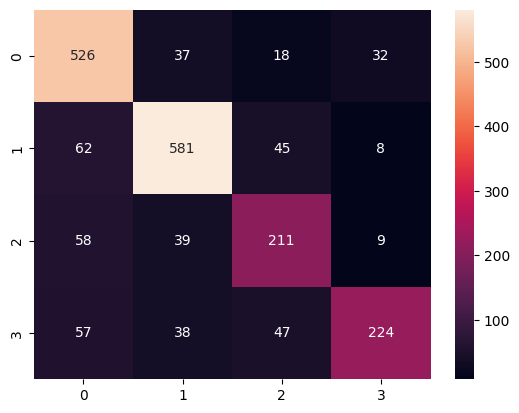

In [30]:
conf=confusion_matrix(Y_test, preds_classes)
sns.heatmap(conf, annot=True, fmt='d')